# Предсказание оттока

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### План работы:



1. Preprocessing данных:

    1. Первичное исслеодование признаков,

    2. Поиск повторяющихся записей, 

    3. Поиск и заполнение пропусков, 

    4. Конвертация типов данных

2. EDA: 

    1. Анализ категориальных признаков,

    2. Анализ non-категориальных признаков, 

    3. Исследование целевой переменной,

3. Построение модели:

	1. Работа с признаками:
		* Использование даты,
		* Удаление ненужных признаков,
	2. Построение модели:
		* Тестирование моделей и их сравнение,
		* Preprocessing - поиск оптимальных параметров предобработки данных,
		* Ансамблирование
		* Анализ полученных результатов
	3. Тестирование модели

4. Вывод



## 1. Preprocessing

### 1.1. Первичное исследование признаков

In [1]:
import pandas as pd
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [2]:
contract = pd.read_csv('contract.csv', index_col= 'customerID')
personal = pd.read_csv('personal.csv', index_col= 'customerID')
internet = pd.read_csv('internet.csv', index_col= 'customerID')
phone = pd.read_csv('phone.csv', index_col= 'customerID')

Строим единый датасет, где Primal Key - `customerID`

In [3]:
frames = [contract, personal, internet, phone]

In [4]:
for f in frames:
    print(f.shape)

(7043, 7)
(7043, 4)
(5517, 7)
(6361, 1)


Произведём присоединение данных - приосединяем к большей таблице меньшие, дабы не потерять информацию. 

In [5]:
df = contract.join(personal).join(internet).join(phone)

Посмотрим информацию о признаках в наших данных.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

In [7]:
# Приведение наименований признаков к нижнему регистру 

df.columns = [f.lower() for f in list(df.columns)]

In [8]:
# Сохраняем наимнование признаков в массив

cols = list(df.columns)

In [9]:
df['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [10]:
# Выводим уникальные значения для каждого признака (кроме дат) и кол-во пропусков.

for c in cols[2:]:
    print(f"Feature: {c} ->  {df[c].unique()}, Nan count: {df[c].isna().sum()}\n")
    

Feature: type ->  ['Month-to-month' 'One year' 'Two year'], Nan count: 0

Feature: paperlessbilling ->  ['Yes' 'No'], Nan count: 0

Feature: paymentmethod ->  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'], Nan count: 0

Feature: monthlycharges ->  [29.85 56.95 53.85 ... 63.1  44.2  78.7 ], Nan count: 0

Feature: totalcharges ->  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5'], Nan count: 0

Feature: gender ->  ['Female' 'Male'], Nan count: 0

Feature: seniorcitizen ->  [0 1], Nan count: 0

Feature: partner ->  ['Yes' 'No'], Nan count: 0

Feature: dependents ->  ['No' 'Yes'], Nan count: 0

Feature: internetservice ->  ['DSL' 'Fiber optic' nan], Nan count: 1526

Feature: onlinesecurity ->  ['No' 'Yes' nan], Nan count: 1526

Feature: onlinebackup ->  ['Yes' 'No' nan], Nan count: 1526

Feature: deviceprotection ->  ['No' 'Yes' nan], Nan count: 1526

Feature: techsupport ->  ['No' 'Yes' nan], Nan count: 1526

Feature: streamingtv ->  ['

У нас имеется 7043 записей о пользователях, где имеются следующие признаки:
* BeginDate / EndDate - дата составления договора и его окончание. Если договор действующий - EndDate не указан. 
* Type - тип договора. Может быть следующими значениями:
    * Помесячная оплата (Month-to-month)
    * Годовая (One year)
    * Раз в два года (Two year)
* PaperlessBilling - оплата производится по платёжным документам или через электонный счёт. 
* PaymentMethod - вид оплаты. Указыват на тип оплаты - через банковский перевод, кредитной картой, электронный счёт, счёт на почту. 
* monthlycharges / totalcharges - абонентская плата. Сколько клиент платит в месяц / сколько всего заплатил. 
* gender - пол абонента
* seniorcitizen - является ли пожилым абонентом
* partner - находится ли абонент в отношениях
* dependents - является ли иждивенцем 

Следующие признаки относятся к дополнительным услугам, подключенным клиенту. В данной категории присутствуют пропуски, природу которых мы разберём ниже:
* internetservice - тип подключения: 
    * DSL 
    * Оптическое волокно (Fiber optic)
* onlinesecurity - защита от вредоносных сайтов
* onlinebackup - имеется ли услуга Онлайн-бэкапа данных. 
* deviceprotection - антивирус
* techsupport - оплачена услуга поддержки (выделенная линия)
* streamingtv - услуга стримингово ТВ
* streamingmovies - услуга просмотра фильмов онлайн
* multiplelines - имеет несколько выделенных линий. 


Последний признак по большей части относится к телефонному подключению. 


Среди данных отсутствует целевой признак - `churn`, однако мы его можем получить по данным из даты окончания договора. Если договор закончился - клиент ушёл. Создадим целевое значение: 
    * 0 - если действующий клиент
    * 1 - если ушёл

In [11]:
def create_churn(dataframe):
    """
    Create churn target with enddate information
    """
    # Create empty churn col
    dataframe['churn'] = 0
    churn_list = []
    
    for i in range(dataframe.shape[0]):
        enddate = dataframe.iloc[i].enddate
        churn = dataframe.iloc[i].churn
        
        if enddate == 'No':
            churn = 'No'
        else: 
            churn = 'Yes'
        churn_list.append(churn)
    return churn_list
               
df['churn'] = create_churn(df)

In [12]:
df.head()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,No
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes


### 1.2 Проверка на повторяющиеся значения.

In [13]:
# Кол-во повторов

df.duplicated().sum()

13

In [14]:
# Удаляем повторы

df = df.drop_duplicates()
df.duplicated().sum()

0

### 1.3 Поиск и заполнение пропусков

Исходя из первичного анализа мы увидели, что у нас много пропусков в "дополнительных услугах" (~1500). Они могли появиться при объединении таблиц. Для того, чтобы избавиться от пропусков добавим новые категории - "No phone" для пользователей только интернета и "No int" для пользователей телефона. 

In [15]:
df.isna().sum()

begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1515
onlinesecurity      1515
onlinebackup        1515
deviceprotection    1515
techsupport         1515
streamingtv         1515
streamingmovies     1515
multiplelines        682
churn                  0
dtype: int64

In [16]:
df.multiplelines.fillna("No phone", inplace = True)
df.isna().sum()

begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1515
onlinesecurity      1515
onlinebackup        1515
deviceprotection    1515
techsupport         1515
streamingtv         1515
streamingmovies     1515
multiplelines          0
churn                  0
dtype: int64

In [17]:
df.fillna('No internet', inplace = True)
df.isna().sum()

begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
gender              0
seniorcitizen       0
partner             0
dependents          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
multiplelines       0
churn               0
dtype: int64

### 1.3 Приведение данных к нужному типу. 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7030 non-null   object 
 1   enddate           7030 non-null   object 
 2   type              7030 non-null   object 
 3   paperlessbilling  7030 non-null   object 
 4   paymentmethod     7030 non-null   object 
 5   monthlycharges    7030 non-null   float64
 6   totalcharges      7030 non-null   object 
 7   gender            7030 non-null   object 
 8   seniorcitizen     7030 non-null   int64  
 9   partner           7030 non-null   object 
 10  dependents        7030 non-null   object 
 11  internetservice   7030 non-null   object 
 12  onlinesecurity    7030 non-null   object 
 13  onlinebackup      7030 non-null   object 
 14  deviceprotection  7030 non-null   object 
 15  techsupport       7030 non-null   object 
 16  streamingtv       7030 non-null 

In [19]:
# BeginDate to datetime
# EndDate fill No values with specific data (1994-01-01) and convert to datetime

df.begindate = pd.to_datetime(df['begindate'])
df.enddate = df.enddate.replace('No','1994-01-01 00:00:00')
df.enddate = pd.to_datetime(df['enddate'], errors= 'coerce')

In [20]:
# Convert SeniorCitizen to "Yes No"

df.loc[df.seniorcitizen==1, ('seniorcitizen')] = 'Yes'
df.loc[df.seniorcitizen==0, ('seniorcitizen')] = 'No'

In [21]:
# totalcharges To numeric. Fill uncorrect data to NaT -> fill totalcharges median. 

df.monthlycharges = pd.to_numeric(df.monthlycharges, downcast='float', errors='coerce')
df.totalcharges = pd.to_numeric(df.totalcharges, downcast='float', errors='coerce')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7030 non-null   datetime64[ns]
 1   enddate           7030 non-null   datetime64[ns]
 2   type              7030 non-null   object        
 3   paperlessbilling  7030 non-null   object        
 4   paymentmethod     7030 non-null   object        
 5   monthlycharges    7030 non-null   float32       
 6   totalcharges      7019 non-null   float32       
 7   gender            7030 non-null   object        
 8   seniorcitizen     7030 non-null   object        
 9   partner           7030 non-null   object        
 10  dependents        7030 non-null   object        
 11  internetservice   7030 non-null   object        
 12  onlinesecurity    7030 non-null   object        
 13  onlinebackup      7030 non-null   object        
 14  deviceprotecti

После перевода у нас появились пропуски в totalcharges. Заполним их медианными значениями.

In [23]:
df.totalcharges.fillna(df.totalcharges.median(), inplace = True)

### Выводы по предобработке:

* Нам даны 4 таблицы, в которых хранятся информация о клиентах, их тарифах и об услугах
* В процессе обработки таблицы были объединены, в результате чего появились пропуски в данных. 
    Данные пропуски говорят о том, что есть пользователи без интернета / без телефона. Для таких пользователей были выделены отдельные категории. 
* Наблюдались дублирующиеся данные (13 строк), которые были удалены. 
* Была произведена конвертация признаков исходя из их значений. TotalCharges | MonthCharges приведелны к float64.

## 2. EDA

### 2.1 Анализ категориальных признаков


Для начала выделим эти признаки при помощи функции.

In [24]:
def cat_creator(dataframe):
    """
    input: dataframe
    process: calculate unique values in all columns -> if more then 5 - it's categorical
    output: list of category features
    """
    cats = []
    cols = list(dataframe.columns)
    for c in cols:
        if dataframe[c].nunique() < 5:
            cats.append(c)
            
    return cats


cats = cat_creator(df)
pprint(cats)

['type',
 'paperlessbilling',
 'paymentmethod',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'multiplelines',
 'churn']


Большая часть из наших признаков являются категориальными. 

#### Пол и возраст (seniorcitizen)

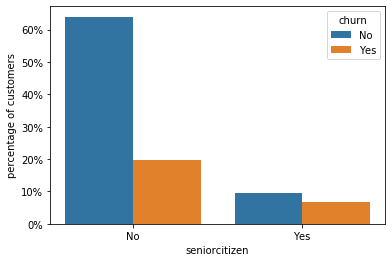

In [25]:
import seaborn as sns



def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    # Create table with cat / churn relations
    g = df.groupby(feature)["churn"].value_counts().to_frame()
    g = g.rename({"churn": axis_name}, axis=1).reset_index()
    
    # Create X with coefs
    g[axis_name] = g[axis_name]/len(df)
    
    
    # Choose orientation of plot
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
    
    
barplot_percentages("seniorcitizen")

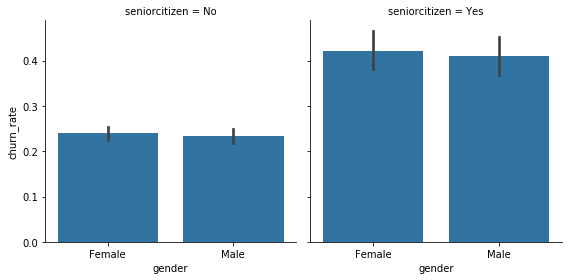

In [26]:
df['churn_rate'] = df['churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(df, col="seniorcitizen", height=4)
ax = g.map(sns.barplot, "gender", "churn_rate", order= ['Female', 'Male'])

* Пол не является важным признаком
* Пожилые люди являются малой частью от клиентов, но у них сильно выше процент оттока

#### Partners, dependents

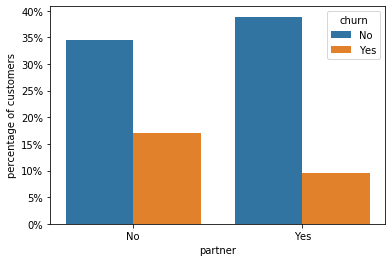

In [27]:
barplot_percentages("partner")

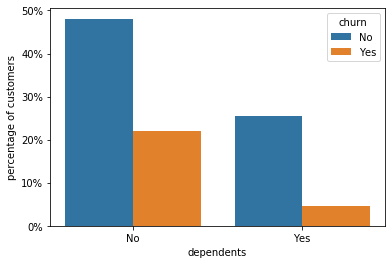

In [28]:
barplot_percentages("dependents")


* Клиенты, у которых нет партнеров, с большей вероятностью могут отказаться от услуг.
* Клиенты без иждивенцев также более склонны к уходу. 


#### Phone and Internet services

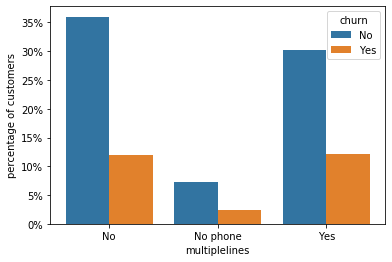

In [29]:
barplot_percentages("multiplelines")

* Малая часть клиентов не использует телефон

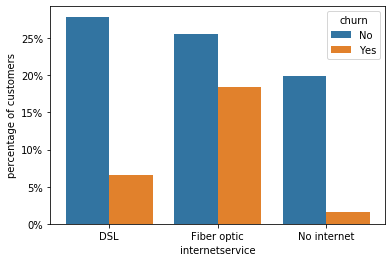

In [30]:
barplot_percentages("internetservice")

* Люди, использующие оптическое волокно, чаще уходят. Может быть связано с высокой конкуренцией, так как в доме могут быть несколько операторов,
* Клиенты без интернета имеют очень маленький процент оттока.

#### Анализ сервисов 

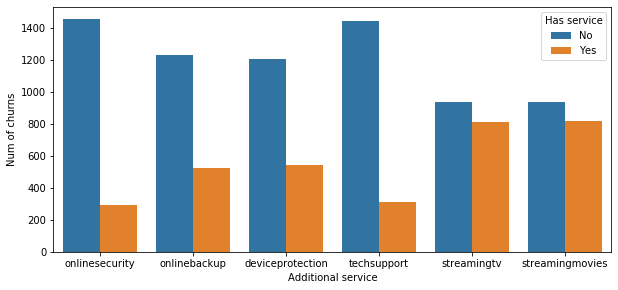

In [31]:
import matplotlib.pyplot as plt

cols = ["onlinesecurity", "onlinebackup", "deviceprotection", "techsupport", "streamingtv", "streamingmovies"]
df1 = pd.melt(df[df["internetservice"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
df1 = df[(df.internetservice != "No") & (df.churn == "Yes")]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

* Стриминговые сервисы не сильно влияют на отток
* Клиенты, использующие остальные сервисы реже уходят. 


#### Payment info


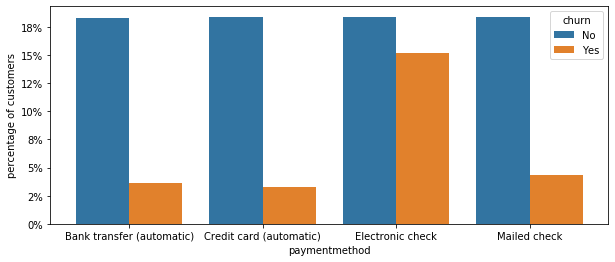

In [32]:
plt.figure(figsize = (10,4))
barplot_percentages("paymentmethod")

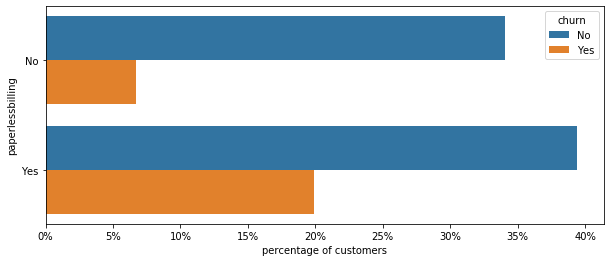

In [33]:
plt.figure(figsize = (10,4))
barplot_percentages("paperlessbilling", orient = 'h')

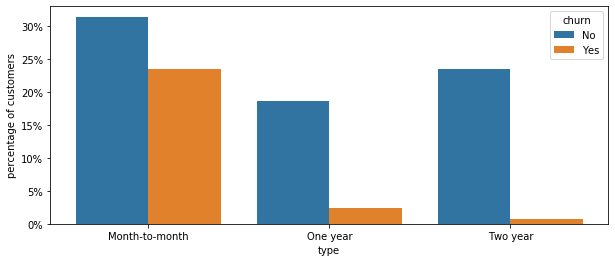

In [34]:
plt.figure(figsize = (10,4))
barplot_percentages("type", orient = 'v')

* Самый высокий процент оттока у клиентов с электронной оплатой (electronic check)
* Клиенты, использующий электронный документооборот, чаще отказываются от услуг
* Переход к ежегодной оплате за услуги процент оттока сильно снижается (с 25% до >5%)


### 2.2 Non-категориальные признаки

У нас имеется всего два признака, в которых не категориальные признаки - сумма месячной оплаты и общая сумма.

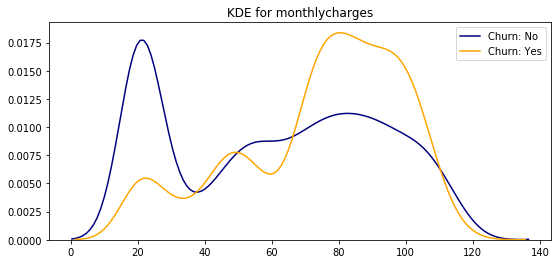

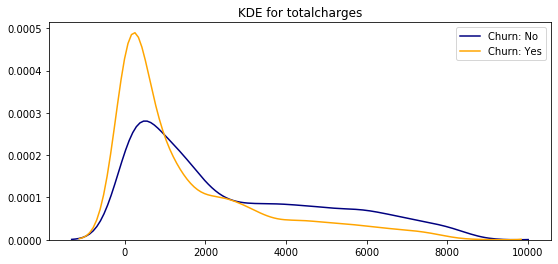

In [35]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
    
kdeplot('monthlycharges')
kdeplot('totalcharges')

На основании полученного распределения можно сказать, что основным признаком, по которому можно предсказать отток, является величина месечной платы. 

Это видно на двух пиках первого распределения - no churn на величине ~ 20 и churn на величине оплаты более 70. 

### 2.3 Распределение целевого признака.

Посмотрим на баланс целевого признака (отто|ка).

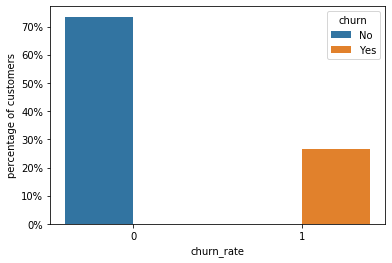

In [36]:
barplot_percentages('churn_rate')

Соотношение класов ~ 75 к 30.

## 3. Построение модели.

### 3.1 Работа с признаками
#### Использование даты

Для выбора лучшей модели мы используем библиотеку PyCaret.

Для начала, добавим новый признак к нашим данным - сколько лет / месяцев абонент "с нами".

Наши данные актуальны на февраль 2020.


In [86]:
# Текущая дата

import numpy as np

curr_date = pd.DataFrame(index = df.index, 
                            data = [
                                pd.Series('2020-02-01', dtype='datetime64[ns]') for x in range(len(df))
                            ])
current_series = pd.Series('2020-02-01', dtype='datetime64[ns]')

In [87]:
def with_us(dataframe):
    
    # arr of new days
    days = []
    
    for i in range(len(dataframe)):
        
        #BeginDate
        b_date = dataframe.begindate.dt.date[i]
        
        #EndDate
        e_date = dataframe.enddate.dt.date[i]
        
        #Если дата окончания договора не наступила (клиент не ушёл), то вычитаем из текущей
        if str(e_date) == '1994-01-01':
            day_count = (current_series.dt.date - b_date)
        # Иначе вычитаем из даты окончания
        else:
            day_count = (e_date - b_date)
            
        try:
            days.append(day_count.days)
        except:
            days.append(day_count[0].days)
            
    return days
        
    
        
df['with_us'] = with_us(df)

In [88]:
df.head(5)

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,churn_rate,with_us
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,1994-01-01,Month-to-month,Yes,Electronic check,29.850000,29.850000,Female,No,Yes,...,No,Yes,No,No,No,No,No phone,No,0,31
5575-GNVDE,2017-04-01,1994-01-01,One year,No,Mailed check,56.950001,1889.500000,Male,No,No,...,Yes,No,Yes,No,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.849998,108.150002,Male,No,No,...,Yes,Yes,No,No,No,No,No,Yes,1,61
7795-CFOCW,2016-05-01,1994-01-01,One year,No,Bank transfer (automatic),42.299999,1840.750000,Male,No,No,...,Yes,No,Yes,Yes,No,No,No phone,No,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.699997,151.649994,Female,No,No,...,No,No,No,No,No,No,No,Yes,1,61


#### Удаление признаков

In [43]:
# Удаляем даты, churn_rate
clean_df = df.drop(['churn_rate','begindate','enddate'], axis = 1)

In [44]:
clean_df['churn'].replace(to_replace='Yes', value=1, inplace=True)
clean_df['churn'].replace(to_replace='No',  value=0, inplace=True)

## 3.2 Построение модели

Для дальнейшей работы мы будем использовать библиотеку PyCaret, которая позволяет быстро сравнить модели, а также оптимизировать её параметры. 

### Тестирование моделей

Импортируем библиотеку PyCaret

In [89]:
from pycaret.classification import *

In [107]:
# Производим конфигурирование. 
# Обучающая выборка - 80%

clf_1 = setup(
    data = clean_df,
    target='churn',
    numeric_features=['monthlycharges', 'totalcharges','with_us'],
    train_size = 0.8,
    
)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,3732
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(7030, 19)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,15
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [92]:
# Производим сравнение моделей. Сортировку будем производить по целевой метрике - AUC

compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.864700,0.908800,0.630300,0.818900,0.712000,0.625500
1,Light Gradient Boosting Machine,0.848700,0.894000,0.612200,0.772700,0.682200,0.584700
2,Gradient Boosting Classifier,0.843000,0.888900,0.580700,0.773800,0.662500,0.563000
3,Extreme Gradient Boosting,0.831600,0.878000,0.547200,0.754100,0.633100,0.527500
4,Ada Boost Classifier,0.827000,0.866700,0.562000,0.726700,0.632800,0.522200
5,Logistic Regression,0.804400,0.841100,0.551200,0.657100,0.599000,0.471100
6,Quadratic Discriminant Analysis,0.733600,0.838600,0.814400,0.499600,0.619000,0.432000
7,Linear Discriminant Analysis,0.799600,0.837900,0.563300,0.640400,0.598500,0.465800
8,Naive Bayes,0.740200,0.831800,0.795700,0.507900,0.619600,0.437000
9,Extra Trees Classifier,0.783100,0.806700,0.508400,0.609300,0.553400,0.412000


Лучшие показатели у бустинговых алгоритмов - LightGBM, GBC (sklearn), XGBoost. Для дальнейшей работы используем LightGBM. 

In [152]:
lightgbm = create_model('lightgbm', fold = 7)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8483,0.9003,0.6056,0.7725,0.6789,0.5815
1,0.8420,0.8872,0.5981,0.7574,0.6684,0.5666
2,0.8396,0.8902,0.6028,0.7457,0.6667,0.5626
3,0.8294,0.9044,0.5728,0.7262,0.6404,0.5306
4,0.8344,0.8751,0.6009,0.7273,0.6581,0.5501
5,0.8468,0.8862,0.6150,0.7616,0.6805,0.5813
6,0.8481,0.8987,0.6150,0.7661,0.6823,0.5840
Mean,0.8412,0.8917,0.6015,0.7510,0.6679,0.5652
SD,0.0067,0.0093,0.0132,0.0171,0.0138,0.0182


In [161]:
tuned = tune_model('lightgbm', optimize='AUC', n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8579,0.9108,0.6711,0.7634,0.7143,0.6202
1,0.8579,0.9166,0.6533,0.7778,0.7101,0.6170
2,0.8526,0.9082,0.6400,0.7680,0.6982,0.6017
3,0.8632,0.9157,0.7067,0.7626,0.7336,0.6417
4,0.8381,0.8877,0.5906,0.7458,0.6592,0.5549
5,0.8292,0.8923,0.6107,0.7054,0.6547,0.5420
6,0.8399,0.8861,0.6376,0.7252,0.6786,0.5725
7,0.8808,0.9018,0.6913,0.8306,0.7546,0.6767
8,0.8648,0.9048,0.7047,0.7664,0.7343,0.6438
9,0.8683,0.9214,0.6913,0.7863,0.7357,0.6485


#### Анализ полученной модели

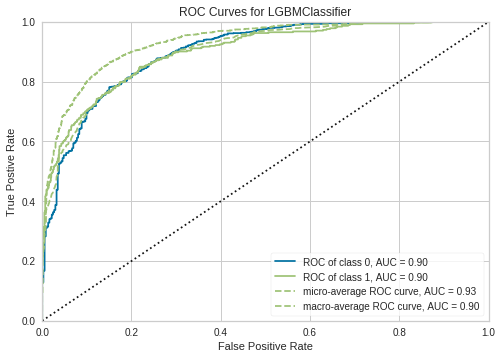

In [162]:
# ROC-AUC curve
plot_model(tuned)

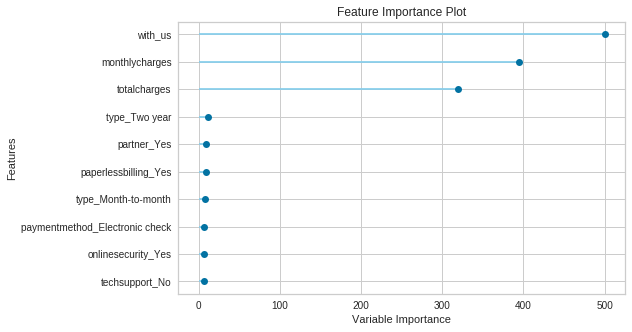

In [163]:
plot_model(tuned, plot ='feature')

Саммыми ценными признаками являются `with_us` и `type`.  

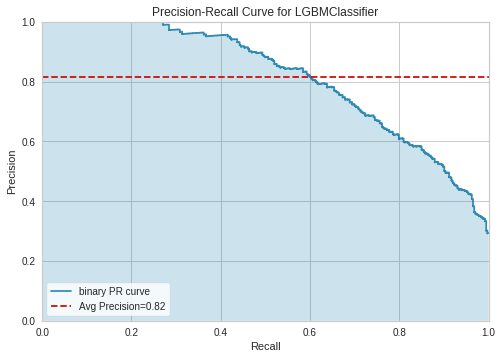

In [164]:
# Precision Recall curve

plot_model(tuned, plot ='pr')

In [165]:
# Model params

plot_model(tuned, plot = 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1
importance_type,split
learning_rate,0.6
max_depth,10
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.1
n_estimators,70


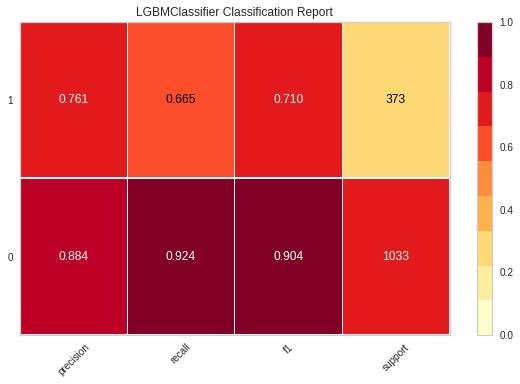

In [166]:
# Classification report

plot_model(tuned, plot = 'class_report')

Протестируем нашу модель на тестовой выборке. 

In [167]:
predicts = predict_model(tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.8556,0.8997,0.6649,0.7607,0.7096,0.6141


AUC ~= 0.9, Accuracy в это время = 85%. 

Значения Recall / Precision = 0.66/0.76

# Общий вывод


Перед нами стояла цель построения модели прогнозирования ухода клиент. Для этого нам были переданы данные, содержащие информацию об абонентах, их договорах, данные об оплате. 

Ключевым параметров является параметр "Churn", который отсутствовал в изначальных данных. Этот признак был извлечён из даты окончания договора. 

Признаком успешной модели является значение AUC на тестовой выборке > 0.88 (6 sp).

В процессе работы с данными была выполнена следующая работа:
* Поиск повторяющихся значений и их удаление;
* Поиск и анализ пропусков. На данном этапе у нас появились пропуски из-за объединения талбиц. Некоторые пользователи являлись пользователями только интернета или только телефона;
* Конвертация типов данных. Некоторые из признаков имели некорректный тип данных. 
    
Далее, был произведён анализ данных, который состоял из отдельного анализа категоиральных признаков, числовых признаков, а также анализ целевой переменной. 

По результатам анализа можно сказать, что:
* Почти все признаки из полученных являются категориальными;
* Пожилые абоненты являтеся малой частью клиентов, однако процент оттока у них выше;
* Люди без партнёров и без иждивенцев (детей) более склонны к уходу;
* Абоненты, использующие оптическое волокно, чаще уходят. Может быть связано с высокой конкуренцией, так как в доме могут быть несколько операторов;
* Стриминговые сервисы не влияют на отток, однако люди, использующие остальные услуги реже уходят;
* Стоит обратить внимание на клиентов с помесячной оплатой. Процент оттока у них выше, чем при других контрактах;
* Основным признаком для определения оттока служит сумма месячной оплаты.

В процессе работы были выявлены следующие проблемы:
* Отсутствовал целевой признак - churn.
    * *решение: Использовали дату окончания договора для создания признака*
   
* Несбалансированная выборка - в наших данных соотношение ушедших клиентов и оставшихся не равное. Это влияет на качество обучения модели, а также на объективность метрик:
    * *решение 1: Увеличить кол-во данных и, если соотношение не изменится, сэмплированием сбалансировать данные*

Для построения модели мы добавили новый признак - сколько дней клиент с нами, а также убрали нерелевантные признаки - даты. 

Лучшие показатели на наших данных показала модель LightGBM, результаты которой на тестовой выборке:

* Accuracy = 0.85
* AUC ~= 0.9
* Recall/Precision = 0.66/0.76

Данные показатели соответствуют поставленной задачи и могут быть интерпретированы как:
* Модель успешно предсказала отток клиентов в 85% случаев (Accuracy)
* Precision - процент реально ушедших клиентов от общего числа предсказанных уходов = 66%
* Recall - процент реально ушедших клиентов от всех предсказаний = 76%

